In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import tonic
from IPython.display import HTML #for frame animation

import matplotlib.pyplot as plt
import numpy as np

In [2]:


dtype=torch.float
torch.manual_seed(734)
print("Convolutional SNN Trained on DVS Gesture")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=1 #TODO 256 might cause OOM
data_path='./tmp/data/DVS'
num_classes = 11  # DVS has 10 output classes, one for out of class
temporal_filters = 6
filter_delay = 16
downsample_size = (64,64)

transform = tonic.transforms.Compose([ tonic.transforms.Downsample(sensor_size=(128,128),target_size=downsample_size), tonic.transforms.ToFrame(sensor_size=(*downsample_size,2),time_window=1000) ])
#downsample to constent with paper + helps save memory

train_dvs = tonic.datasets.DVSGesture(data_path,train=True,transform=transform)
test_dvs = tonic.datasets.DVSGesture(data_path,train=False,transform=transform)
#TODO consider using  DiskCachedDataset for performance

train_loader = DataLoader(train_dvs, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(test_dvs, batch_size=batch_size, shuffle=True,drop_last=False)


#time step is 1000 microseconds i.e. 1ms


Convolutional SNN Trained on DVS Gesture
Using device: cuda


(5799, 2, 64, 64)
(2, 64, 64)


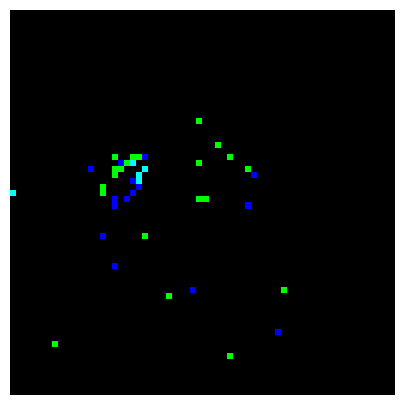

In [3]:
a = train_dvs[1]
print(a[0].shape)
print(a[0][0].shape)
animation = tonic.utils.plot_animation(np.clip(a[0][0:100],0,1))
HTML(animation.to_jshtml())


In [11]:
# okay from our frames to create a temporal cascade layer, we are going to have streams of event frames that are seperated by a 16ms delay
#TODO events are stacked so may have multiple events ina  frame  - do i need to clip

frames=a[0]

def temporal_filter(data):

    cascade_frames = torch.empty((*data.shape[:-3],temporal_filters, *data.shape[-3:]),device=device)

    

    if (len(data.shape) == 4): #is unbatched data
        n = data.shape[0]
        for i in range(temporal_filters):
            cascade_frames[0:(16*i),i,:] = 0
            cascade_frames[(16*i):,i,:] = data[:n-(16*i),:]

    elif (len(data.shape) == 5): #batched data
        n = data.shape[1]
        for i in range(temporal_filters):
            cascade_frames[:,0:(16*i),i,:] = 0
            cascade_frames[:,(16*i):,i,:] = data[:,:n-(16*i),:]

    else:
        raise ValueError("data is incorrect size (to be batched or unbatched) - shape: ",data.shape)



    #merge features into one dimension
    cascade_frames = torch.reshape(cascade_frames,(*cascade_frames.shape[:-4],12,*downsample_size))
    return cascade_frames

#test with unbatched data
csf = temporal_filter(torch.from_numpy(frames))
print(csf.shape)

#TODO test with batched data, this also requires padding with zeros s.t. all samples are same length, & using a dataloader - https://tonic.readthedocs.io/en/latest/tutorials/batching.html
# unless you want to use batches of temporal frame snapshots from both random samples & times 

# this shit eats memory like crazy






torch.Size([5799, 12, 64, 64])


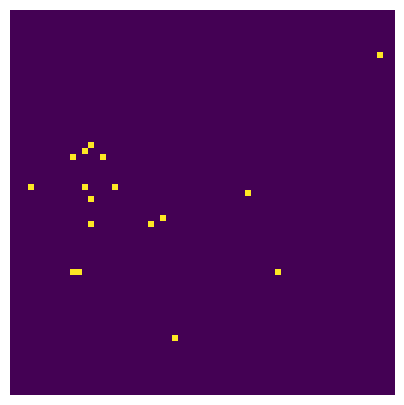

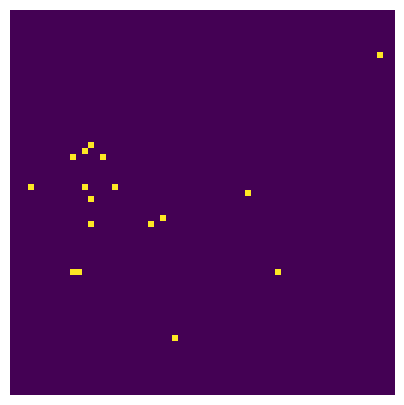

d:\Program Files\Python\Python310\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


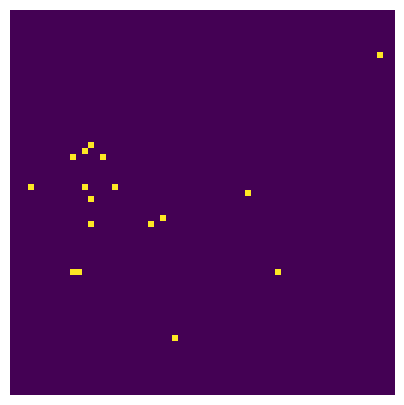

In [13]:
#can see that the frames are delayed properly

tonic.utils.plot_animation(csf[100,0:2].cpu())
tonic.utils.plot_animation(csf[100+16,2:4].cpu())
tonic.utils.plot_animation(csf[100+16+16+16,6:8].cpu())

In [14]:
### lets take a look at the tonic DVS dataset
#this only works for dataset without transform
events,labels = test_dvs[0]
tonic.utils.plot_event_grid(events,axis_array=(1,5))
print(events.shape)
print(events[5])

TypeError: argument of type 'NoneType' is not iterable

In [15]:
################ DVS Gesture Model #############################

# (without temporal layer - this is up for interpretation)

# layer parameters
num_inputs = 28*28
num_hidden1 = 300
num_hidden2 = 100
num_outputs = 10
num_steps = 26  # for spike encoding
beta = 1 /32
lr=5e-3
#weight_decay=1e-6

spike_grad1 = surrogate.atan() 

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        #from table 1 in DVS paper
        #TODO im multiplying features by two as paper states 6 input features, but we have seperate channels for increase/decrease events
        self.linears = nn.ModuleList([
            #64x64
            nn.Conv2d(6*2,12*2,3,2,0,1,1),
            nn.Conv2d(12*2,252*2,4,2,0,1,2),
            nn.Conv2d(252*2,256*2,1,1,0,1,2),
            nn.Conv2d(256*2,256*2,2,2,0,1,2),
            nn.Conv2d(256*2,512*2,3,1,1,1,32),
            nn.Conv2d(512*2,512*2,1,1,0,1,4),
            nn.Conv2d(512*2,512*2,1,1,0,1,4),
            nn.Conv2d(512*2,512*2,1,1,0,1,4),
            nn.Conv2d(512*2,512*2,2,2,0,1,16),
            nn.Conv2d(512*2,1024*2,3,1,1,1,64),
            nn.Conv2d(1024*2,1024*2,1,1,0,1,8), #typo in table here
            nn.Conv2d(1024*2,1024*2,1,1,0,1,8),
            nn.Conv2d(1024*2,1024*2,2,2,0,1,32),
            nn.Conv2d(1024*2,1024*2,1,1,0,1,8),
            nn.Conv2d(1024*2,968*2,1,1,0,1,8),
            nn.Conv2d(968*2,2640*2,1,1,0,1,8)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=beta,spike_grad=spike_grad1)] * 16
        )


        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data

        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(16):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        x = temporal_filter(x)

        for step in range(num_steps):
            spk_i = x[step] #for encoded input

            for i in range(16):
                print("I:",i)
                print("spk_i:",spk_i.shape)
                cur_i = self.linears[i](spk_i)
                spk_i, mem[i] = self.neurons[i](cur_i,mem[i])
        spk_rec.append(spk_i)

        return (spk_rec,mem) #TODO do i really need to return membrane potentials
    
###################################################################################



In [16]:
#test if forward pass works with data
net = Net().to(device)
net.train()
sample = test_dvs[0][0]
print(sample.shape)
print(sample.nbytes / 1000000000) # 300 MB native, 7MB 64x64, jesus

#sample_tf = temporal_filter(torch.from_numpy(sample).to(device)).to(device)
#print(sample_tf.shape)
#print(sample_tf.nbytes / 1000000000) #3.6 GB native, 0.89 64x64
out = net.forward(torch.from_numpy(sample).to(device))
print(out[0][0].shape)



## fdownsampling helps avoid OOM
### btw check this out https://open-neuromorphic.org/blog/truenorth-deep-dive-ibm-neuromorphic-chip-design/
# and this https://github.com/rbnprdy/TrueNorthSimulator

(4568, 2, 64, 64)
0.074842112
I: 0
spk_i: torch.Size([12, 64, 64])
I: 1
spk_i: torch.Size([24, 31, 31])
I: 2
spk_i: torch.Size([504, 14, 14])
I: 3
spk_i: torch.Size([512, 14, 14])
I: 4
spk_i: torch.Size([512, 7, 7])
I: 5
spk_i: torch.Size([1024, 7, 7])
I: 6
spk_i: torch.Size([1024, 7, 7])
I: 7
spk_i: torch.Size([1024, 7, 7])
I: 8
spk_i: torch.Size([1024, 7, 7])
I: 9
spk_i: torch.Size([1024, 3, 3])
I: 10
spk_i: torch.Size([2048, 3, 3])
I: 11
spk_i: torch.Size([2048, 3, 3])
I: 12
spk_i: torch.Size([2048, 3, 3])
I: 13
spk_i: torch.Size([2048, 1, 1])
I: 14
spk_i: torch.Size([2048, 1, 1])
I: 15
spk_i: torch.Size([1936, 1, 1])
I: 0
spk_i: torch.Size([12, 64, 64])
I: 1
spk_i: torch.Size([24, 31, 31])
I: 2
spk_i: torch.Size([504, 14, 14])
I: 3
spk_i: torch.Size([512, 14, 14])
I: 4
spk_i: torch.Size([512, 7, 7])
I: 5
spk_i: torch.Size([1024, 7, 7])
I: 6
spk_i: torch.Size([1024, 7, 7])
I: 7
spk_i: torch.Size([1024, 7, 7])
I: 8
spk_i: torch.Size([1024, 7, 7])
I: 9
spk_i: torch.Size([1024, 3, 3])


In [18]:
########### STATS ##############

def print_stats(data, targets):
    output, _ = net(data.view(data.size(0), -1))
    acc  = net.accuracy_metric(output, targets)
    #dev = np.std((targets == idx).detach().cpu().numpy()) #TODO deviation for latency encoding
    print(f"    Accuracy: {acc*200:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}, Minibatch stats:")
    print(f"    Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"    Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_stats(data, targets)
    print_stats(test_data, test_targets)
    print("\n")


##############################


# Load the network onto CUDA
net = Net().to(device)

loss = functional.loss.ce_rate_loss()
optimiser = torch.optim.Adam(net.parameters(),lr=lr)


num_epochs = 1
loss_hist = []
test_loss_hist = []

img_counter = 0 #total no. of images iterated over

#training loop
for epoch in range(num_epochs):
    batch_counter=0 #image number within current batch

    train_batches = iter(train_loader)

    #mini-batch loop
    for data, targets in train_batches:

        print("data: ",data.shape)
        print("targets: ",targets.shape)

        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train() #inform pytorch
        spk_rec, mem_rec = net(data)

        #calculate loss as cross entropy of membrane potential at each step
        loss_val = net.loss(spk_rec,targets)

        
        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)
            net.eval()

            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = net.loss(test_spk,test_targets)
            test_loss_hist.append(test_loss.item())
            # Print train/test loss/accuracy
            if img_counter % 50 == 0:
                train_printer()
            img_counter += 1
            batch_counter +=1


###############################################################################################

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples
#test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    print("Test Set: ")
    print_stats(data,targets)

###TODO: change loss functions, latency encoding,
# can we implement STDP?

#Notes:
#training time is almost double

data:  torch.Size([1, 6931, 2, 64, 64])
targets:  torch.Size([1])
I: 0
spk_i: torch.Size([6931, 12, 64, 64])
I: 1
spk_i: torch.Size([6931, 24, 31, 31])


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.55 GiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 15.27 GiB is allocated by PyTorch, and 954.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF